 # Проект: Обучение с учителем: качество модели

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и этот отдел поможет с прогнозами.


**Цель исследования**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Что нам известно**

В нашем распоряжении четыре датасета с данными, вот какая информация в них содержится:
    
    
**market_file.csv**


Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


•	id — номер покупателя в корпоративной базе данных.

•	Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

•	Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

•	Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

•	Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

•	Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

•	Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

•	Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

•	Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

•	Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

•	Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

•	Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

•	Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


**market_money.csv**


Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


•	id — номер покупателя в корпоративной базе данных.

•	Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

•	Выручка — сумма выручки за период.


**market_time.csv**


Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.


•	id — номер покупателя в корпоративной базе данных.

•	Период — название периода, во время которого зафиксировано общее время.

•	минут — значение времени, проведённого на сайте, в минутах.


**money.csv**


Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


•	id — номер покупателя в корпоративной базе данных.

•	Прибыль — значение прибыли.


**Ход исследования**
 
 - Подготовим данные: загрузим и изучим общую информацию из предоставленных датасетов;
 - предобработаем данные: обработаем пропущенные значения, найдем дубликаты, скорректируем типы данных;
 - проведем исследовательский анализ данных;
 - объединим таблицы;
 - проведем корреляционный анализ данных;
 - построим пайплайны, обучим четыре модели и выберем лучшую;
 - проведем анализ важности признаков;
 - проведем сегментацию покупателей;
 - сформулируем общий вывод.

Приступим к работе.

## Загрузка данных

На этом этапе загрузим библиотеки и инструменты.

In [230]:
!pip install scikit-learn==1.1.3 -q
!pip install shap -q
!pip install phik -q
!pip install numba

### Загрузим библиотеки и инструменты

In [231]:
import shap 
import pandas as pd
import numpy as np 
from scipy import stats as st 
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import math

In [232]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, f1_score
import warnings
import phik
import shap
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузим данные таблиц

Загрузим и прочтем данные из таблиц, посмотрим основную информацию.

In [233]:
#переименуем таблицы для удобства
market = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

In [234]:
#посмотрим основную информацию
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [235]:
#посмотрим первые строки таблицы
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [236]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [237]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [238]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [239]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [240]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [241]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В таблицах отсутствуют пропуски — количество значений в столбцах соответствует количеству строк.
Типы данных, на первый взгляд, адекватны содержимому столбцов.
Названия стоблцов нужно «причесать», их содержимое — проверить данные на явные и неявные дубликаты.

## Предобработка данных

На этом этапе переименуем столбцы, проверим дубликаты.

### Переименуем столбцы

In [242]:
#переименуем столбцы
market = market.rename(columns={'Покупательская активность':'активность',
                                'Тип сервиса':'сервис', 
                                'Разрешить сообщать':'рассылка', 
                                'Маркет_актив_6_мес':'актив_6_мес', 
                                'Маркет_актив_тек_мес':'актив_тек_мес', 
                                'Длительность':'длительность', 
                                'Акционные_покупки':'акции', 
                                'Популярная_категория':'категория', 
                                'Средний_просмотр_категорий_за_визит':'категорий_за_визит', 
                                'Неоплаченные_продукты_штук_квартал':'неоплачено_штук', 
                                'Ошибка_сервиса':'ошибки', 
                                'Страниц_за_визит':'страницы'})

 
market_money = market_money.rename(columns={'Период': 'период', 
                                  'Выручка': 'выручка'})

 
time = time.rename(columns={'Период':'период', 
                            'минут':'минуты'})

 
money = money.rename(columns={'Прибыль':'прибыль'})

#проверим, что получилось
market.columns, market_money.columns, time.columns, money.columns

(Index(['id', 'активность', 'сервис', 'рассылка', 'актив_6_мес',
        'актив_тек_мес', 'длительность', 'акции', 'категория',
        'категорий_за_визит', 'неоплачено_штук', 'ошибки', 'страницы'],
       dtype='object'),
 Index(['id', 'период', 'выручка'], dtype='object'),
 Index(['id', 'период', 'минуты'], dtype='object'),
 Index(['id', 'прибыль'], dtype='object'))

### Проверим явные дубликаты

In [243]:
market.duplicated().sum()  

0

In [244]:
market_money.duplicated().sum()  

0

In [245]:
time.duplicated().sum() 

0

In [246]:
money.duplicated().sum()  

0

In [247]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1300 non-null   int64  
 1   активность          1300 non-null   object 
 2   сервис              1300 non-null   object 
 3   рассылка            1300 non-null   object 
 4   актив_6_мес         1300 non-null   float64
 5   актив_тек_мес       1300 non-null   int64  
 6   длительность        1300 non-null   int64  
 7   акции               1300 non-null   float64
 8   категория           1300 non-null   object 
 9   категорий_за_визит  1300 non-null   int64  
 10  неоплачено_штук     1300 non-null   int64  
 11  ошибки              1300 non-null   int64  
 12  страницы            1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


In [248]:
# попутно приведем в приличный вид содержимое столбцов
cols = ['активность', 'сервис', 'рассылка', 'категория']
for i in cols:
    market[i] = market[i].str.lower()
    market[i] = market[i].str.replace(' ', '_') 

### Проверим неявные дубликаты

In [249]:
market['активность'].unique()

array(['снизилась', 'прежний_уровень'], dtype=object)

In [250]:
market['сервис'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [251]:
# нашлась явная опечатка
market['сервис'] = market['сервис'].replace('стандартт','стандарт')

In [252]:
market['сервис'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [253]:
market['рассылка'].unique()

array(['да', 'нет'], dtype=object)

In [254]:
market['категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [255]:
# и  тут опечатка
market['категория'] = market['категория'].replace('косметика и аксесуары','косметика и аксессуары')

In [256]:
market['категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [257]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [258]:
time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [259]:
# о, и тут опечатка
time['период'] = time['период'].replace('предыдцщий_месяц','предыдущий_месяц')

In [260]:
time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Мы провели необходимую предобработку данных: привели названия столбцов к змениному регистру, выяснили, что явных дубликатов нет, неявные — нашли и поправили.

## Исследовательский анализ данных

На этом шаге проведем исследовательский анализ данных из каждой таблицы и отберем клиентов с покупательской активностью не менее трёх месяцев — то есть таких, которые что-либо покупали в этот период.  

### Построим гистограммы для таблицы market

In [261]:
# составим функцию для построения гистограммы диаграммы размаха для столбцов с количественными признаками
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x=data[column], color='Indigo')

In [262]:
# составим список количественных столбцов датасета market
num_col_market = ['актив_6_мес', 
                  'актив_тек_мес', 
                  'длительность', 
                  'акции',
                  'категорий_за_визит',
                  'неоплачено_штук', 
                  'ошибки', 
                  'страницы']

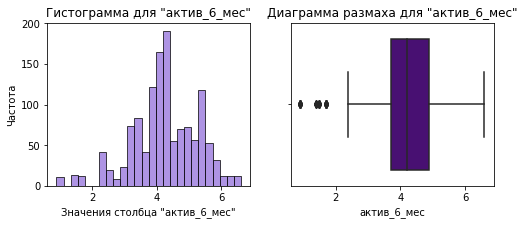

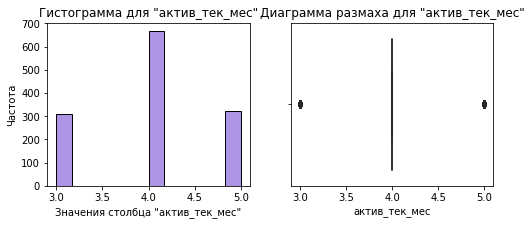

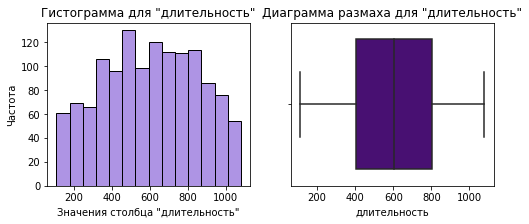

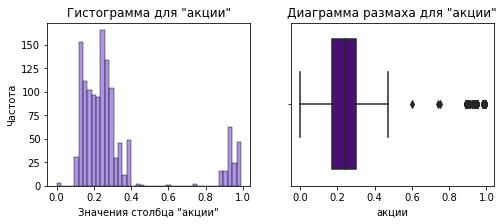

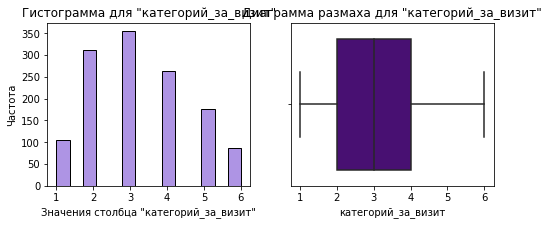

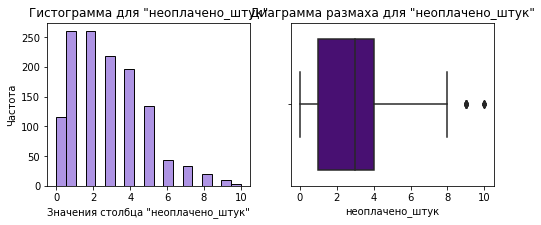

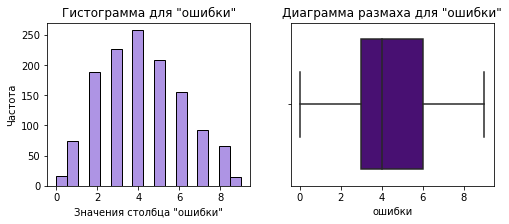

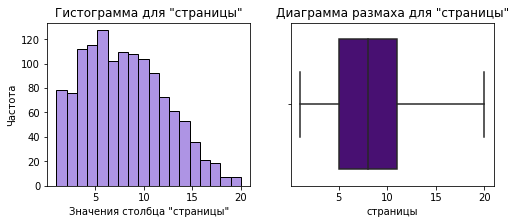

In [263]:
# построим распределение количественных признаков датасета market
for name in num_col_market:
    hist_box(market, name)

- Признак актив_6_мес в целом распределен нормально, есть несколько слишком маленьких значений — возможно придется их удалить, но пока не хочется торопиться;
- признак актив_тек_мес теоретически можно сделать категориальным признаком с 3-мя категориями;
- признак длительность в целом распределен равномерно на всём диапазоне значений;
- признак акции имеет бимодальное распределение - в области 0,2 и в области близкой к 1. Есть немалая доля покупателей, кто покупает только по акции! К ним нужно присмотреться повнимательней;
- признак категорий_за_визит имеет нормальное распределение, можно сделать категориальным признаком с 6 категориями;
- признак неоплачено_штук имеет слегка скорешенное влево распределение - редко кто хранит в корзине больше 8 предметов - будет категориальным признаком с 11 категориями;
- признак ошибки распределен нормально - будет категориальным признаком с 10 категориями;
- признак страницы имеет слегка скошенное влево нормальное распределение.

### Построим гистограммы для таблицы market_money

In [264]:
# составим список количественных столбцов датасета m_money
num_col_market_money = ['выручка'] 

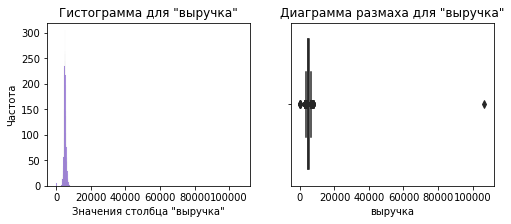

In [265]:
# построим распределение количественных признаков датасета m_money
for name in num_col_market_money:
    hist_box(market_money, name)

In [266]:
# найдем выбросы
market_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [267]:
# удалим аномалию
market_money = market_money[market_money['выручка'] < 100000]

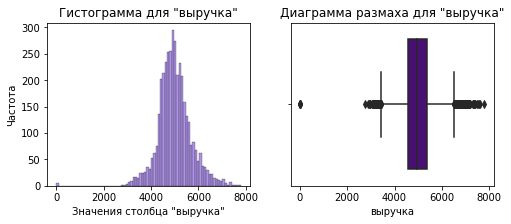

In [268]:
# построим распределение количественных признаков датасета m_money без выбросов
for name in num_col_market_money:
    hist_box(market_money, name)

In [269]:
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Периодов с нулевой выручкой. Это плохие записи, потому что мы хотим в дальнейшем использовать только тех пользователей, у которых есть активность за три месяца, а такие пустые записи явно нам помешают.

In [270]:
market_money = market_money[market_money['выручка'] > 0]

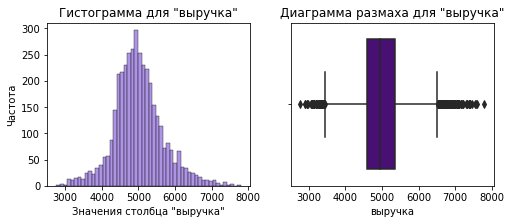

In [271]:
for name in num_col_market_money:
    hist_box(market_money, name)

### Построим гистограммы для таблицы time

In [272]:
#создание списка количественных столбцов датасета m_money
num_col_time = ['минуты'] 

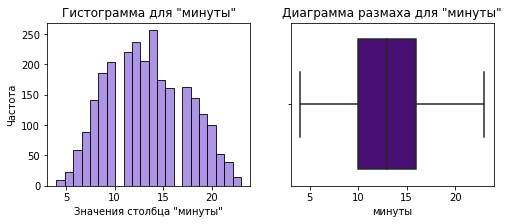

In [273]:
#построение распределений количественных признаков датасета time
for name in num_col_time:
    hist_box(time, name)


### Построим гистограммы для таблицы money

In [274]:
#создание списка количественных столбцов датасета m_money
num_col_money = ['прибыль'] 

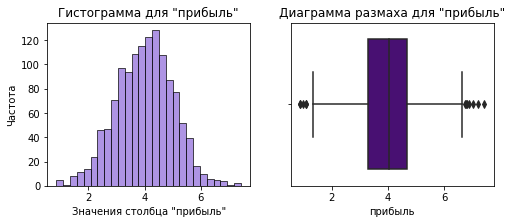

In [275]:
for name in num_col_money:
    hist_box(money, name)

In [276]:
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph(dataset, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)[name].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))

In [277]:
#создание списка категориальных признаков датасета market
cat_col_market = ['активность', 'сервис', 'рассылка', 'категория']

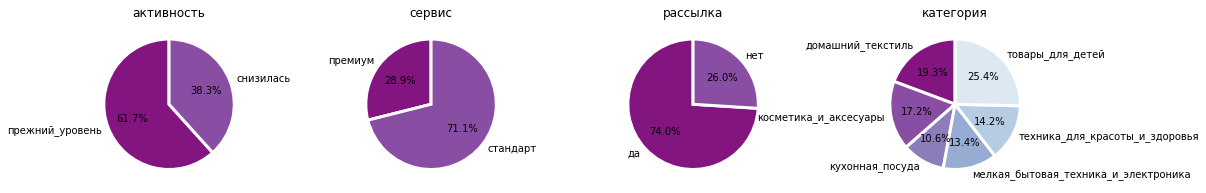

In [278]:
#круговые диаграммы для датасета market
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_market:
    pie_graph(market, name, 'id', len(cat_col_market), i)
    i += 1

In [279]:
#создание списка категориальных признаков датасета m_money
cat_col_market_money = ['период']

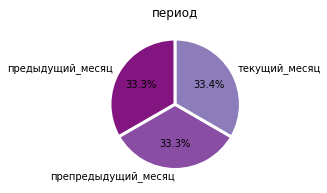

In [280]:
#круговые диаграммы для датасета m_money
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_market_money:
    pie_graph(market_money, name, 'id', len(cat_col_market_money), i)
    i += 1

In [281]:
#создание списка категориальных признаков датасета time
cat_col_time = ['период']

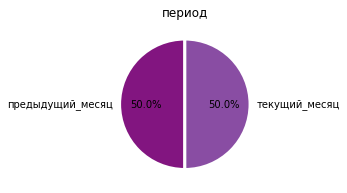

In [282]:
#круговые диаграммы для датасета time
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_time:
    pie_graph(time, name, 'id',len(cat_col_time), i)
    i += 1

### Оценим покупательскую активность

In [283]:
#выбор пользователей, не принесших выручку в течение последних 3 месяцов
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market = market[market['id'].isin(grouped.index)]
len(market)

1296

## Объединение таблиц

Теперь объединим данные из датафреймов market, market_money, time в одну таблицу.

In [284]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)

#проверим, что получилось
market_full.head(5)

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

Text(0.5, 1.0, 'Матрица корреляции')

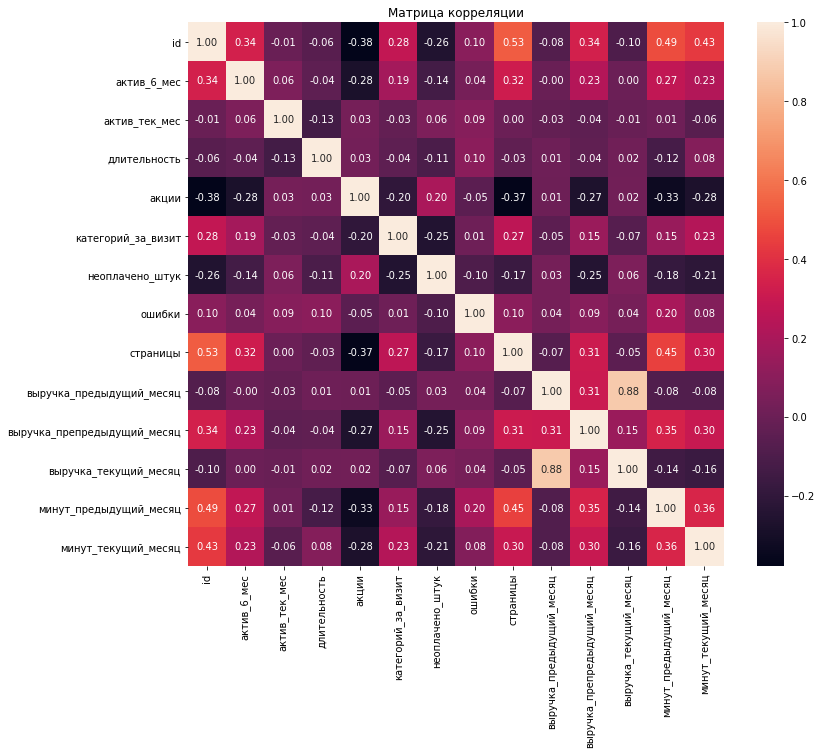

In [285]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(market_full.corr(method="spearman"), annot=True, fmt='.2f')
plt.title('Матрица корреляции')

Вывод

## Пайплайны

### Подготовим данные

In [286]:
# подготовим данные. Закодируем целевой признак в значение 0 и 1
market_full['активность'] = market_full['активность']\
.apply( lambda x: 1 if x=='снизилась' else 0 )
market_full['активность'] = market_full['активность'].astype(int)    

In [287]:
# превратим колонку Акционные_покупки в категоральный признак
market_full['акции_частота'] = market_full['акции']\
.apply( lambda x: 'часто_покупает_по_акции' if x>= 0.5 else 'редко_покупает_по_акции' )
market_full = market_full.drop(['акции'], axis=1)

In [288]:
market_full = market_full.set_index('id')

In [289]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   активность                   1296 non-null   int64  
 1   сервис                       1296 non-null   object 
 2   рассылка                     1296 non-null   object 
 3   актив_6_мес                  1296 non-null   float64
 4   актив_тек_мес                1296 non-null   int64  
 5   длительность                 1296 non-null   int64  
 6   категория                    1296 non-null   object 
 7   категорий_за_визит           1296 non-null   int64  
 8   неоплачено_штук              1296 non-null   int64  
 9   ошибки                       1296 non-null   int64  
 10  страницы                     1296 non-null   int64  
 11  выручка_предыдущий_месяц     1296 non-null   float64
 12  выручка_препредыдущий_месяц  1296 non-null   float64
 13  выручка_тек

In [290]:
market_full.head()

,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,часто_покупает_по_акции
215350,1,стандарт,нет,4.9,3,539,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,редко_покупает_по_акции
215351,1,стандарт,да,3.2,5,896,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,часто_покупает_по_акции
215352,1,стандарт,нет,5.1,3,1064,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,часто_покупает_по_акции
215353,1,стандарт,да,3.3,4,762,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,редко_покупает_по_акции


In [291]:
X = market_full.drop(['активность'], axis=1)
y = market_full['активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [292]:
X_train.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции
215715,премиум,да,3.6,5,873,товары_для_детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,редко_покупает_по_акции


In [293]:
ohe_columns = ['сервис', 'рассылка', 'категория']
ord_columns = ['акции_частота']
num_columns = ['актив_6_мес',
               'актив_тек_мес',
               'длительность',
               'категорий_за_визит',
               'неоплачено_штук',
                'ошибки',
               'страницы', 
               'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц', 
               'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 
               'минут_текущий_месяц']

### Закодируем данные и создадим пайплайн

In [294]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse=False))
    ]
)

In [295]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['редко_покупает_по_акции','часто_покупает_по_акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [296]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [297]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [298]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [299]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [300]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(sparse=False))]),
                                                                               ['сервис',
                                                                                'рассылка',
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_imputer_ord_before',
                                                                                                SimpleImputer(stra...
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [301]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['сервис', 'рассылка',
                                                   'категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                               

In [302]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [303]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

Метрика F1-score на тестовой выборке: 0.9


## Анализ важности признаков

TypeError: set_ticks() got an unexpected keyword argument 'fontsize'

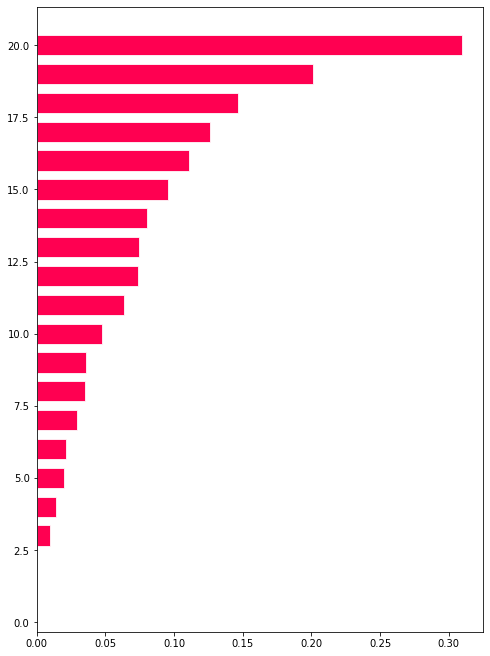

In [304]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)
 
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=15)

## Сегментация покупателей

In [305]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [306]:
X_test.head(3)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,техника_для_красоты_и_здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,редко_покупает_по_акции
215654,премиум,нет,1.4,4,684,товары_для_детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,часто_покупает_по_акции
216307,премиум,да,3.3,4,488,домашний_текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,редко_покупает_по_акции


In [307]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)

In [308]:
df_full.head(5)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции,0.063481,4.37
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции,0.780925,4.03
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции,0.084637,4.37
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции,0.676069,5.58
215715,премиум,да,3.6,5,873,товары_для_детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,редко_покупает_по_акции,0.752113,4.87


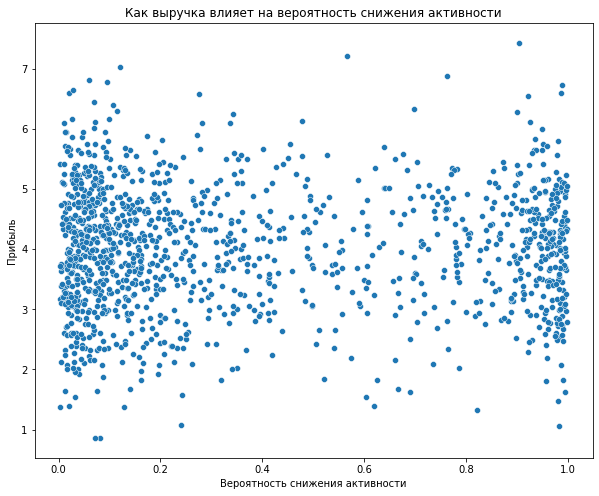

In [309]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Как выручка влияет на вероятность снижения активности')
plt.show()

In [310]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Как выручка влияет на вероятность снижения активности')
        plt.show()

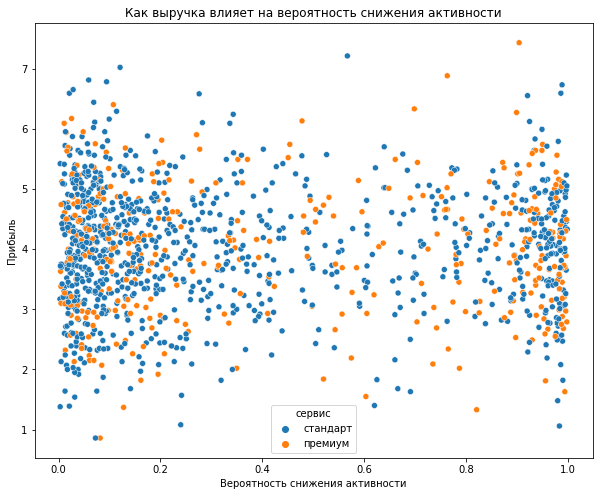

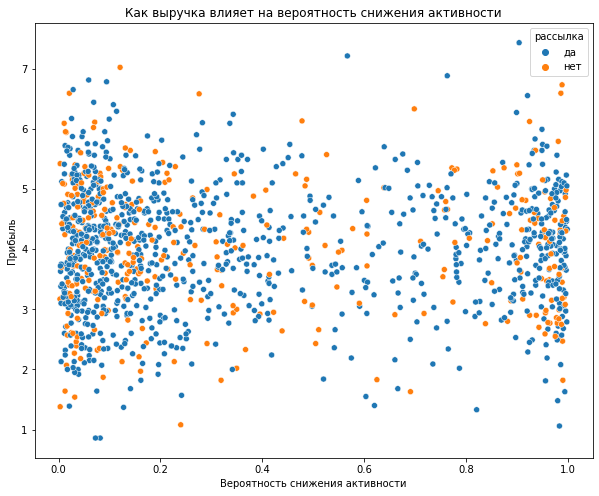

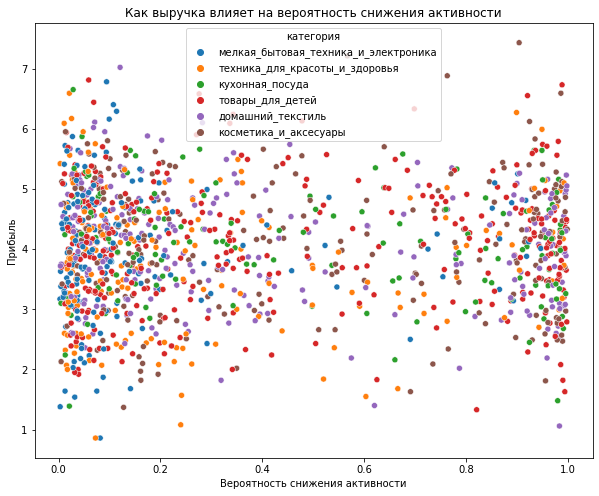

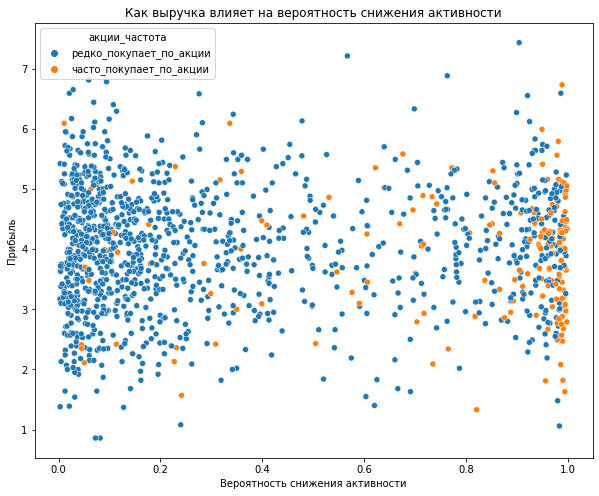

In [311]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

### Сегментация

In [312]:
df_full.head(4)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции,0.063481,4.37
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции,0.780925,4.03
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции,0.084637,4.37
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции,0.676069,5.58


In [313]:
df_full['сегмент'] = df_full\
.apply( lambda row: 'исследуемый_сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акции_частота']=='часто_покупает_по_акции' \
        else 'остальные_пользователи' \
      , axis=1)

In [314]:
df_full['сегмент'].unique() 
print(df_full['сегмент'].value_counts())

остальные_пользователи    1182
исследуемый_сегмент        114
Name: сегмент, dtype: int64


In [315]:
df_invest=df_full.query('сегмент == "исследуемый_сегмент"') 

In [316]:
df_invest.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль,сегмент
id,,,,,,,,,,,,,,,,,,,
215448,премиум,да,4.6,4,974,домашний_текстиль,4,3,3,7,5351.0,4670.0,6129.7,9,10,часто_покупает_по_акции,0.887994,2.95,исследуемый_сегмент
215732,стандарт,нет,3.5,4,663,косметика_и_аксесуары,3,6,4,3,5810.0,4955.0,5772.3,16,11,часто_покупает_по_акции,0.948500,3.51,исследуемый_сегмент
215537,премиум,да,3.9,4,705,косметика_и_аксесуары,3,3,7,4,6121.5,4974.0,6781.9,7,9,часто_покупает_по_акции,0.956345,1.81,исследуемый_сегмент
215741,стандарт,да,4.8,4,563,товары_для_детей,1,5,7,4,3960.0,4809.0,4594.4,10,14,часто_покупает_по_акции,0.952507,4.29,исследуемый_сегмент
215408,премиум,да,2.4,3,666,кухонная_посуда,3,5,1,2,5295.0,4434.0,5029.8,10,12,часто_покупает_по_акции,0.991723,3.68,исследуемый_сегмент


In [317]:
def cat_unique(df, col):
    display(df[col].unique())
    
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

array(['домашний_текстиль', 'косметика_и_аксесуары', 'товары_для_детей',
       'кухонная_посуда', 'техника_для_красоты_и_здоровья',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

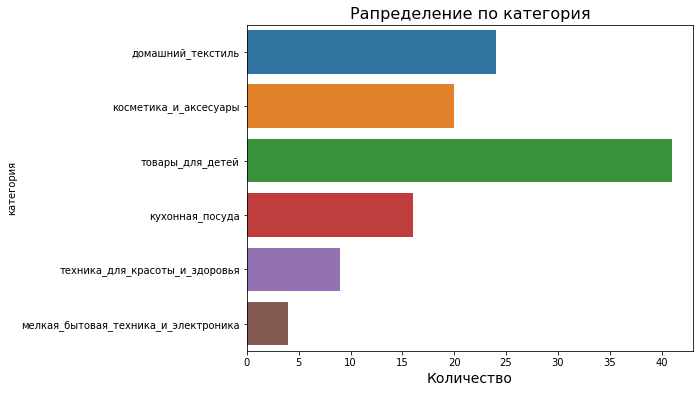

In [318]:
cat_unique(df_invest, 'категория')

array(['премиум', 'стандарт'], dtype=object)

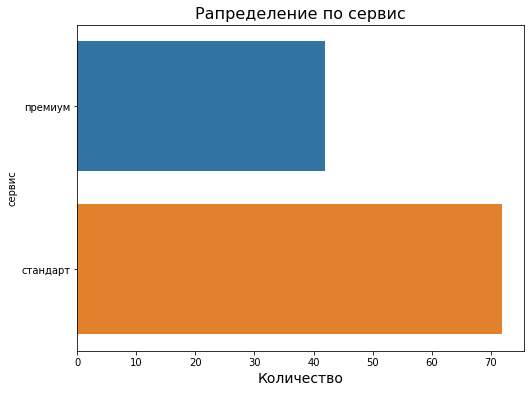

In [319]:
cat_unique(df_invest, 'сервис')

In [320]:
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

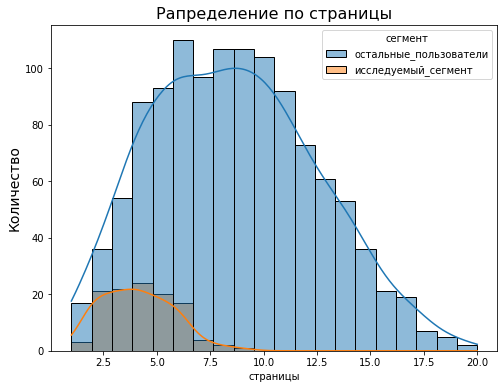

In [321]:
histogram(df_full, 'страницы', 'сегмент')

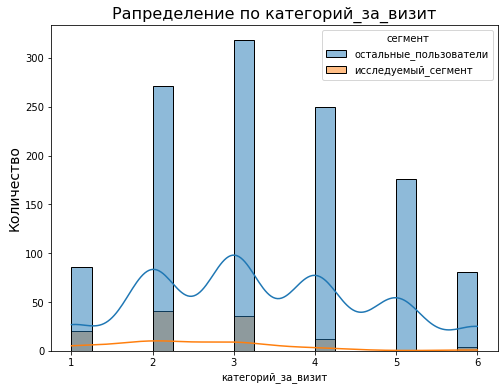

In [322]:
histogram(df_full, 'категорий_за_визит', 'сегмент')

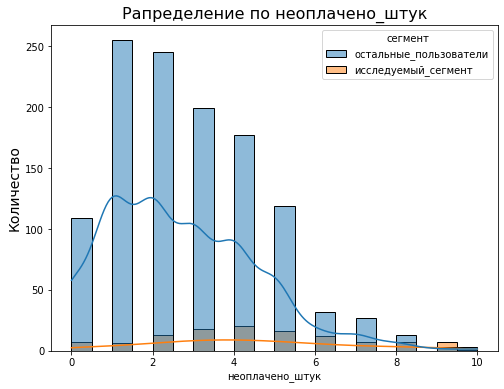

In [323]:
histogram(df_full, 'неоплачено_штук', 'сегмент')

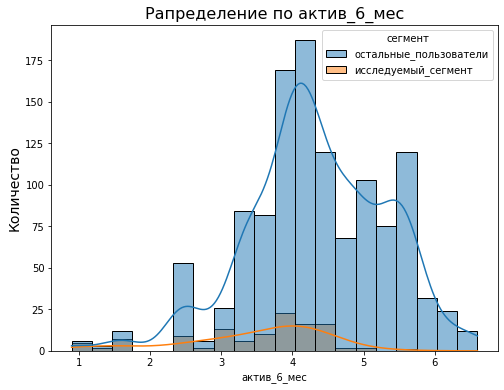

In [324]:
histogram(df_full, 'актив_6_мес', 'сегмент')

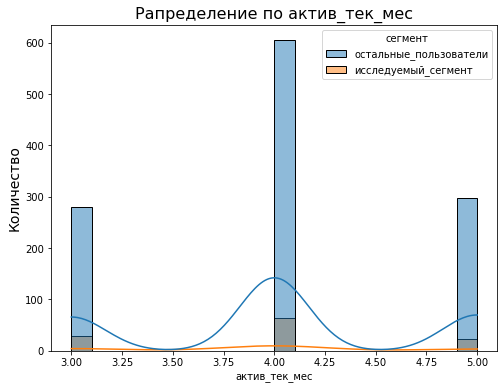

In [325]:
histogram(df_full, 'актив_тек_мес', 'сегмент')